### Project Brief

You are on the data science team for a coffee company that is looking to expand their business into Ukraine. They want to get an understanding of the existing coffee shop market there.

You have a dataset from Google businesses. It contains information about coffee shops in Ukraine. The marketing manager wants to identify the key coffee shop segments. They will use this to construct their marketing plan. In their current location, they split the market into 5 segments. The marketing manager wants to know how many segments are in this new market, and their key features.

You will be presenting your findings to the Marketing Manager, who has no data science background.

The data you will use for this analysis can be accessed here: `"coffee_shops.csv"`

<b> Variables and their definitions: </b>

|Variable|Definition|
|--------|----------|
|Region|Character, one of 10 possible regions where coffee shop is located|
|Place name|Character, name of the shop|
|Place type|Character, the type of coffee shop (e.g., “Cafe”, “Espresso Bar”...)|
|Rating|Numeric, coffee shop rating (on a 5 point scale)|
|Reviews|Numeric, number of reviews provided for the shop|
|Price|Character, price category (e.g., \$, \$\$)|
|Delivery option|True/False, describing, whether there is (or isn’t) a delivery option|
|Dine in option|Column describing whether there is (True) or isn’t (missing) a dine-in option|
|Takeout option|Column describing whether there is (True) or isn’t (missing) a takeout option|


### Table of Contents
---
* [Importing some packages](#Part0) 

* [Loading the data](#Part1) 

* [Exploratory data analysis (EDA)](#Part2)

    * [Univariate analysis](#Part21)

* [Segmentation](#Part3)

* [Results](#Part4)

### Importing some packages <a name="Part0"></a>

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

### Loading the data <a name="Part1"></a>

In [42]:
data = pd.read_csv("data/coffee_shops.csv")
data = data.drop_duplicates()

### Exploratory data analysis (EDA) <a name="Part2"></a>


#### Univariate analysis <a name="Part21"></a>

Let's start from looking through the data.

In [43]:
data.head()

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee store,4.6,206.0,NaN,NaN,NaN,NaN
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,NaN,True
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,NaN,NaN,True
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,True,True
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,NaN,True,True


Now let's check which variables contain missing values and how many.

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           198 non-null    float64
 4   Reviews          198 non-null    float64
 5   Price            122 non-null    object 
 6   Delivery option  129 non-null    object 
 7   Dine in option   140 non-null    object 
 8   Takeout option   144 non-null    object 
dtypes: float64(2), object(7)
memory usage: 15.6+ KB


Let's display some statistics for numeric and categorical features separately.

In [45]:
data.describe()

,Rating,Reviews
count,198.000000,198.000000
mean,4.663636,622.494949
std,0.221648,1400.898666
min,3.900000,3.000000
25%,4.600000,47.500000
50%,4.700000,271.500000
75%,4.800000,786.250000
max,5.000000,17937.000000


In [46]:
data.describe(include=['object'])

,Region,Place name,Place type,Price,Delivery option,Dine in option,Takeout option
count,200,200,200,122,129,140,144
unique,10,187,14,3,2,1,1
top,Kherson,Dim Kavy,Coffee shop,$$,False,True,True
freq,20,4,97,116,94,140,144


Let's display unique values of categorical variables (let's skip "Place name").

In [47]:
for col in [i for i in data.columns 
            if i not in ['Place name', 'Rating', 'Reviews']]:
    print(f'Unique elements of {col} are {list(data[col].unique())}')

Unique elements of Region are ['Mariupol', 'Poltava', 'Kherson', 'Zaporozhye', 'Odessa', 'Lviv', 'Khrivoy Rog', 'Kiev', 'Kharkiv', 'Dnipro']
Unique elements of Place type are ['Coffee store', 'Cafe', 'Coffee shop', 'Espresso bar', 'Chocolate shop', 'European restaurant', 'Internet shop', 'Appliance repair service', 'Store', 'Coffee stand', 'Coffee roasters', 'Pastry shop', 'E-commerce service', 'Restaurant']
Unique elements of Price are [nan, '$$', '$', '$$$']
Unique elements of Delivery option are [nan, False, True]
Unique elements of Dine in option are [nan, True]
Unique elements of Takeout option are [nan, True]


Let's replace "Coffee store" and "Store" categories with "Coffee shop" in "Place type" as they all are the same.

In [48]:
data['Place type'] = data['Place type'].replace(['Coffee store', 'Store'], 
                                                ['Coffee shop', 'Coffee shop'])

Next let's deal with missing values in "Dine option" and "Takeout option". It's very straightforward as the variables' description suggests.

In [49]:
data['Dine in option'].fillna(False, inplace=True)
dio_map_dict = {True: 1, False: 0}
data['Dine in option'] = data['Dine in option'].map(dio_map_dict)

data['Takeout option'].fillna(False, inplace=True)
to_map_dict = {True: 1, False: 0}
data['Takeout option'] = data['Takeout option'].map(to_map_dict)

Let's fill in  missing values in "Reviews".

In [50]:
temp_data = pd.get_dummies(data[['Region', 'Place type']], drop_first=True)
temp_data = pd.concat([temp_data, data[['Dine in option', 'Takeout option', 'Reviews']]], axis=1)

temp_scaler = StandardScaler()
temp_data_scaled = temp_scaler.fit_transform(temp_data)

temp_imputer = KNNImputer(n_neighbors=1)
data['Reviews'] = temp_scaler.inverse_transform(temp_imputer.fit_transform(temp_data_scaled))[:, -1]
data.head()

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee shop,4.6,206.0,NaN,NaN,0,0
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,0,1
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,NaN,0,1
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,1,1
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,NaN,1,1


Let's fill in missing values in "Rating".

In [51]:
temp_data = pd.get_dummies(data[['Region', 'Place type']], drop_first=True)
temp_data = pd.concat([temp_data, 
                       data[['Reviews', 'Dine in option', 
                             'Takeout option', 'Rating']]], 
                      axis=1)

temp_scaler = StandardScaler()
temp_data_scaled = temp_scaler.fit_transform(temp_data)

temp_imputer = KNNImputer(n_neighbors=1)
data['Rating'] = temp_scaler.inverse_transform(temp_imputer.fit_transform(temp_data_scaled))[:, -1]
data.head()

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee shop,4.6,206.0,NaN,NaN,0,0
1,Mariupol,Коферум,Cafe,5.0,24.0,$$,False,0,1
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,NaN,NaN,0,1
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,$$,False,1,1
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,NaN,NaN,1,1


Now let's address the missing values in "Price".

In [52]:
price_map_dict = {'$': 1, '$$': 2, '$$$': 3}
data['Price'] = data['Price'].map(price_map_dict)

temp_data = pd.get_dummies(data[['Region', 'Place type']], drop_first=True)
temp_data = pd.concat([temp_data, 
                       data[['Reviews', 'Rating', 
                             'Dine in option', 'Takeout option',
                             'Price']]], 
                      axis=1)

temp_scaler = StandardScaler()
temp_data_scaled = temp_scaler.fit_transform(temp_data)

temp_imputer = KNNImputer(n_neighbors=1)
data['Price'] = temp_scaler.inverse_transform(temp_imputer.fit_transform(temp_data_scaled))[:, -1]
data.head()

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee shop,4.6,206.0,2.0,NaN,0,0
1,Mariupol,Коферум,Cafe,5.0,24.0,2.0,False,0,1
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,2.0,NaN,0,1
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,2.0,False,1,1
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,2.0,NaN,1,1


Finally let's deal with missing values in the "Delivery option" variable.

In [53]:
do_map_dict = {True: 1, False: 0}
data['Delivery option'] = data['Delivery option'].map(do_map_dict)

temp_data = pd.get_dummies(data[['Region', 'Place type']], drop_first=True)
temp_data = pd.concat([temp_data, 
                       data[['Reviews', 'Rating', 'Price', 
                             'Dine in option', 'Takeout option',
                             'Delivery option']]], 
                      axis=1)

temp_scaler = StandardScaler()
temp_data_scaled = temp_scaler.fit_transform(temp_data)

temp_imputer = KNNImputer(n_neighbors=1)
data['Delivery option'] = temp_scaler.\
                          inverse_transform(temp_imputer.\
                                            fit_transform(temp_data_scaled))[:, -1]
data.head()

,Region,Place name,Place type,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
0,Mariupol,Dim Kavu,Coffee shop,4.6,206.0,2.0,0.0,0,0
1,Mariupol,Коферум,Cafe,5.0,24.0,2.0,0.0,0,1
2,Mariupol,Кофейня Світ Чаю,Coffee shop,5.0,11.0,2.0,0.0,0,1
3,Mariupol,Кофейня Starcoff,Coffee shop,4.4,331.0,2.0,0.0,1,1
4,Mariupol,"Кофейня ""Friend Zone""",Coffee shop,5.0,12.0,2.0,0.0,1,1


Let's check the variables for presence of missing values once more.

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           200 non-null    object 
 1   Place name       200 non-null    object 
 2   Place type       200 non-null    object 
 3   Rating           200 non-null    float64
 4   Reviews          200 non-null    float64
 5   Price            200 non-null    float64
 6   Delivery option  200 non-null    float64
 7   Dine in option   200 non-null    int64  
 8   Takeout option   200 non-null    int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 15.6+ KB


Let's see coffee shops' distribution by region.

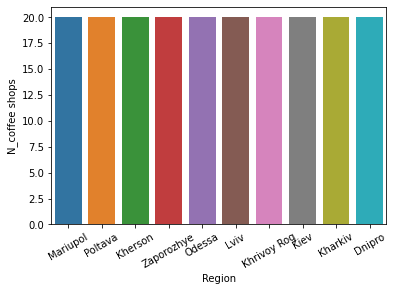

In [55]:
sns.countplot(x='Region', data=data)
plt.xticks(rotation=30)
plt.ylabel('N_coffee shops')
plt.show()

Let's plot coffee shop distribution by regions.

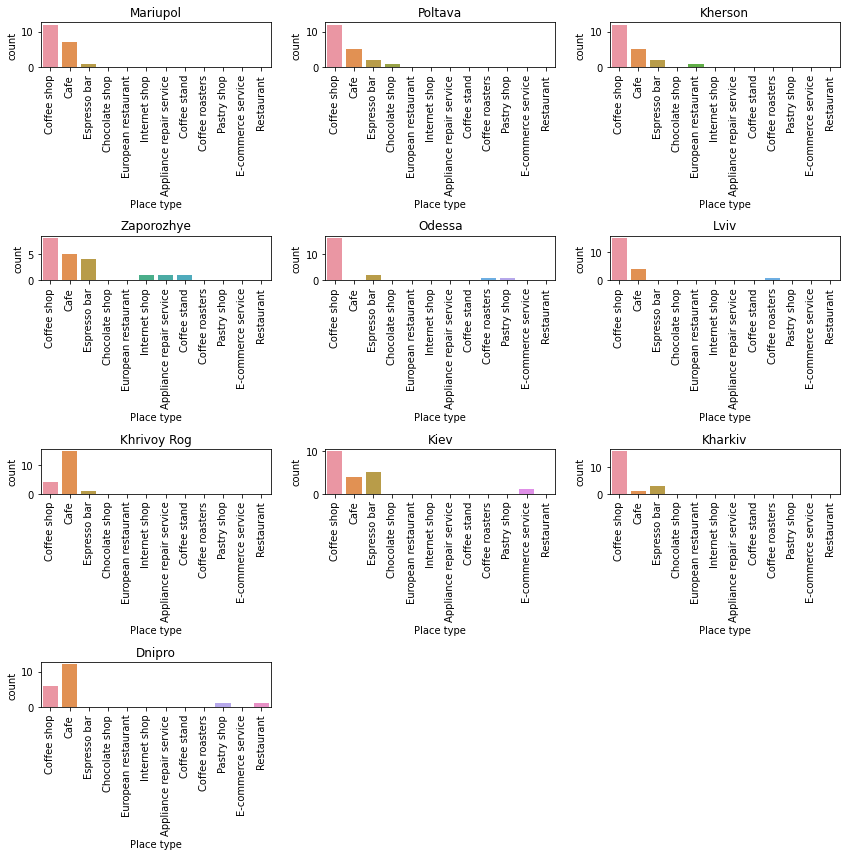

In [56]:
n_subplots = 0
fig = plt.figure(figsize=(12, 12))
for i in data['Region'].unique():
    n_subplots += 1
    plt.subplot(4, 3, n_subplots)
    temp_map_dict = {dio_map_dict[i]: i for i in dio_map_dict}
    temp_df = data[data['Region']==i]
    sns.countplot(x='Place type', data=temp_df, order=[v for v in data['Place type'].unique()])
    plt.xticks(rotation=90)
    plt.title(i)
plt.tight_layout()

Now let's plot "Rating" by region.

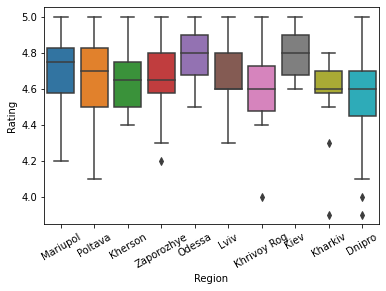

In [57]:
sns.boxplot(x='Region', y='Rating', data=data)
plt.xticks(rotation=30)
plt.show()

Next we'll plot "Reviews" by region.

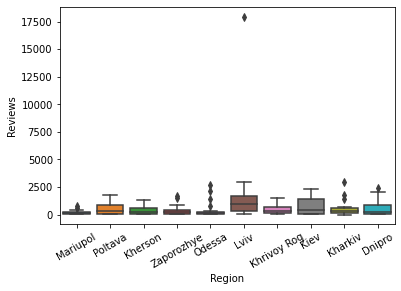

In [58]:
sns.boxplot(x='Region', y='Reviews', data=data)
plt.xticks(rotation=30)
plt.show()

Let's plot "Reviews" by region again neglecting the outlier in the above plot.

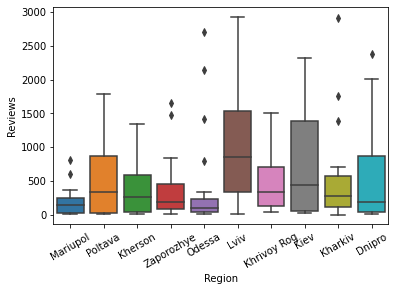

In [59]:
sns.boxplot(x='Region', y='Reviews', data=data[data['Reviews']<15000])
plt.xticks(rotation=30)
plt.show()

Let's visualize "Delivery option" by region.

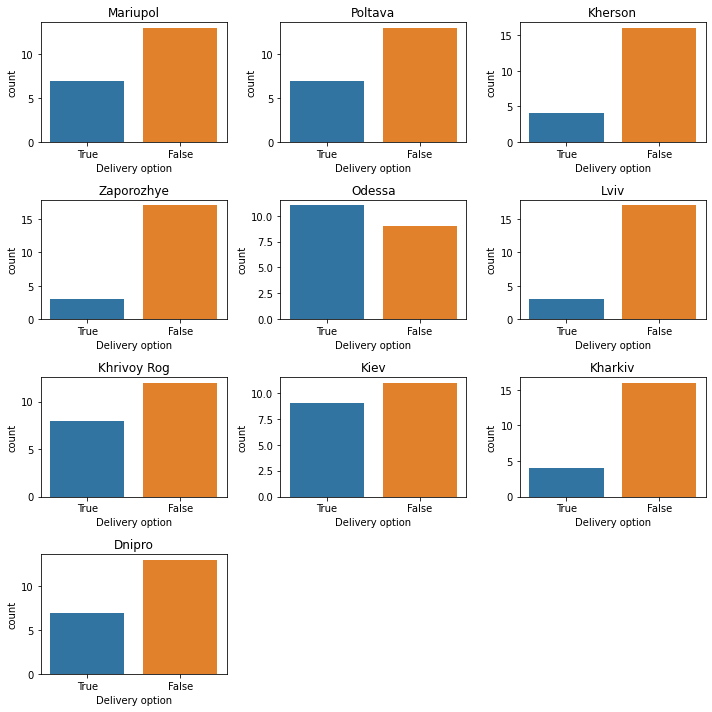

In [60]:
n_subplots = 0
fig = plt.figure(figsize=(10, 10))
for i in data['Region'].unique():
    n_subplots += 1
    plt.subplot(4, 3, n_subplots)
    temp_map_dict = {do_map_dict[i]: i for i in do_map_dict}
    temp_df = data[data['Region']==i]
    temp_df['Delivery option'] = temp_df['Delivery option'].map(temp_map_dict)
    sns.countplot(x='Delivery option', data=temp_df, order=[True, False])
    plt.title(i)
plt.tight_layout()

Now we'll show the distribution of "Dine in option" by region.

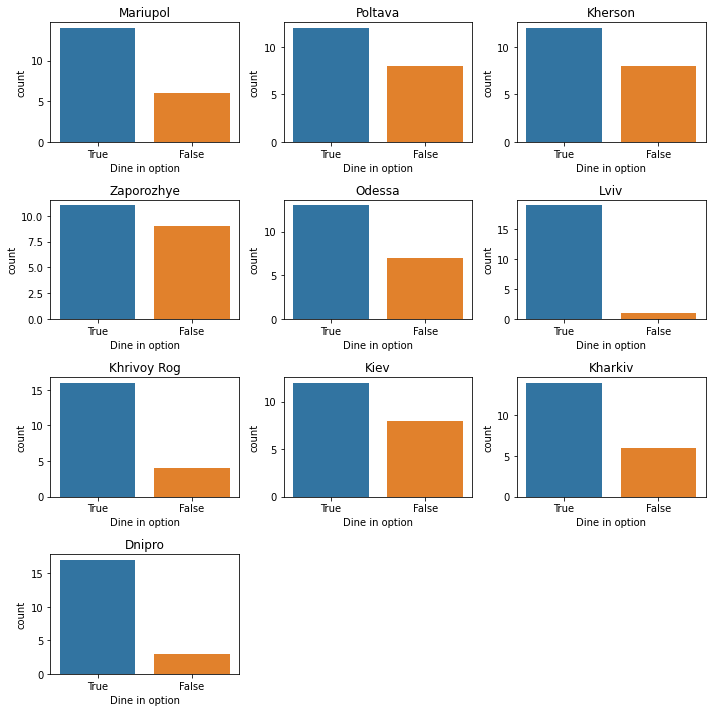

In [61]:
n_subplots = 0
fig = plt.figure(figsize=(10, 10))
for i in data['Region'].unique():
    n_subplots += 1
    plt.subplot(4, 3, n_subplots)
    temp_map_dict = {dio_map_dict[i]: i for i in dio_map_dict}
    temp_df = data[data['Region']==i]
    temp_df['Dine in option'] = temp_df['Dine in option'].map(temp_map_dict)
    sns.countplot(x='Dine in option', data=temp_df, order=[True, False])
    plt.title(i)
plt.tight_layout()

Next we'll plot the distribution of "Takeout option" by the regions.

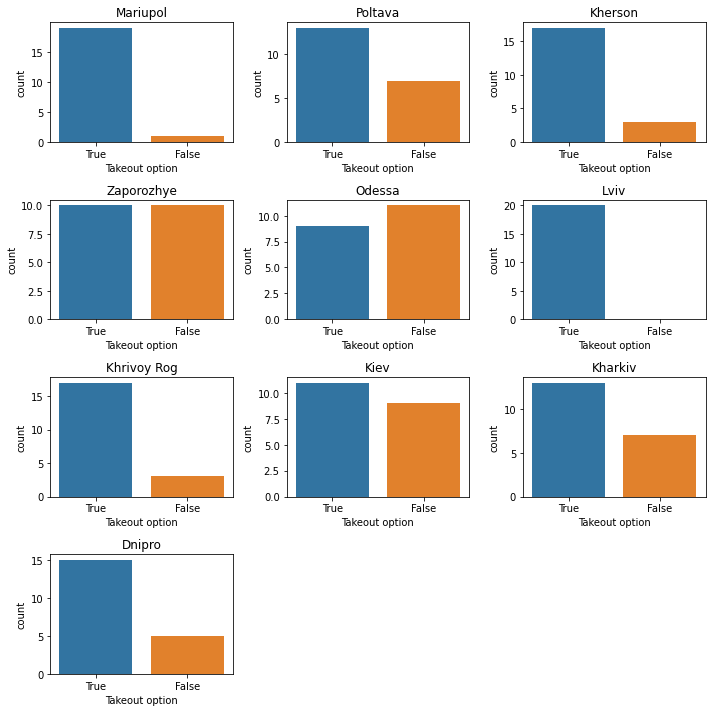

In [62]:
n_subplots = 0
fig = plt.figure(figsize=(10, 10))
for i in data['Region'].unique():
    n_subplots += 1
    plt.subplot(4, 3, n_subplots)
    temp_map_dict = {to_map_dict[i]: i for i in to_map_dict}
    temp_df = data[data['Region']==i]
    temp_df['Takeout option'] = temp_df['Takeout option'].map(temp_map_dict)
    sns.countplot(x='Takeout option', data=temp_df, order=[True, False])
    plt.title(i)
plt.tight_layout()

Finally let's visualize pricing distribution by the regions.

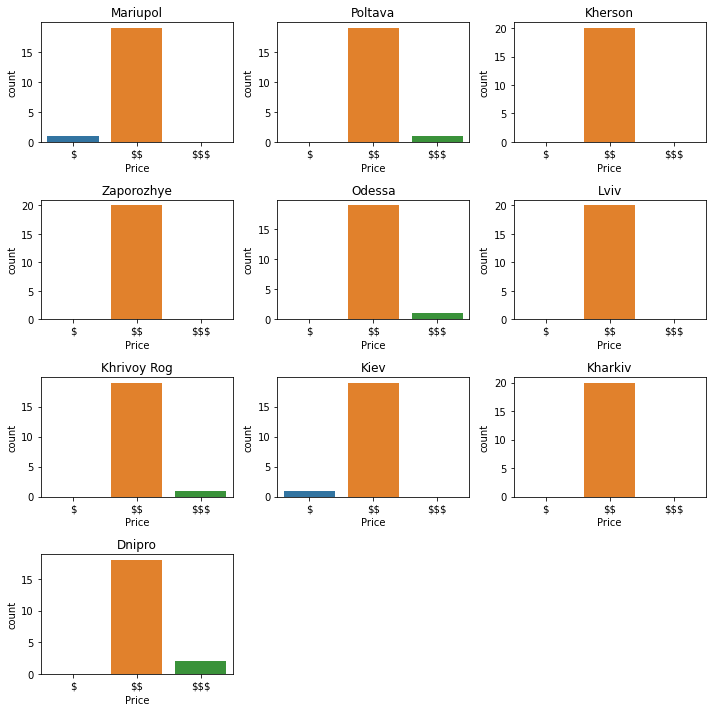

In [63]:
n_subplots = 0
fig = plt.figure(figsize=(10, 10))
for i in data['Region'].unique():
    n_subplots += 1
    plt.subplot(4, 3, n_subplots)
    temp_map_dict = {1: '\$', 2: '\$\$', 3: '\$\$\$'}
    temp_df = data[data['Region']==i]
    temp_df['Price'] = temp_df['Price'].map(temp_map_dict)
    sns.countplot(x='Price', data=temp_df, order=['\$', '\$\$', '\$\$\$'])
    plt.title(i)
plt.tight_layout()

As we can see from the above charts the coffee shop market is quite diverse across Ukraine's regions. Now let's proceed to segment construction.

### Segmentation <a name="Part3"></a>

Let's try to implement hierarchical clustering method to get segments. Before applying it let's do some data wrangling.

In [64]:
data.describe()

,Rating,Reviews,Price,Delivery option,Dine in option,Takeout option
count,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,4.66650,616.540000,2.015000,0.315000,0.700000,0.720000
std,0.22243,1395.106825,0.186949,0.465682,0.459408,0.450126
min,3.90000,3.000000,1.000000,0.000000,0.000000,0.000000
25%,4.60000,44.500000,2.000000,0.000000,0.000000,0.000000
50%,4.70000,264.500000,2.000000,0.000000,1.000000,1.000000
75%,4.80000,780.750000,2.000000,1.000000,1.000000,1.000000
max,5.00000,17937.000000,3.000000,1.000000,1.000000,1.000000


In [65]:
# There is an outlier in "Reviews" so let's get rid of it.
data = data[data['Reviews']<15000]
#temp_data = pd.get_dummies(data[['Region', 'Place type']], drop_first=True)
# modified_data = data[[col for col in data.columns 
#                       if col not in ['Region', 'Place type', 'Place name']]]
# modified_data = pd.concat([modified_data, temp_data], axis=1)
modified_data = data[['Rating', 'Reviews']]
modified_data.head()

,Rating,Reviews
0,4.6,206.0
1,5.0,24.0
2,5.0,11.0
3,4.4,331.0
4,5.0,12.0


Let's apply StandardScaler to the modified data.

In [66]:
temp_scaler = StandardScaler()
scaled_data = temp_scaler.fit_transform(modified_data)

Now we can implement clustering.

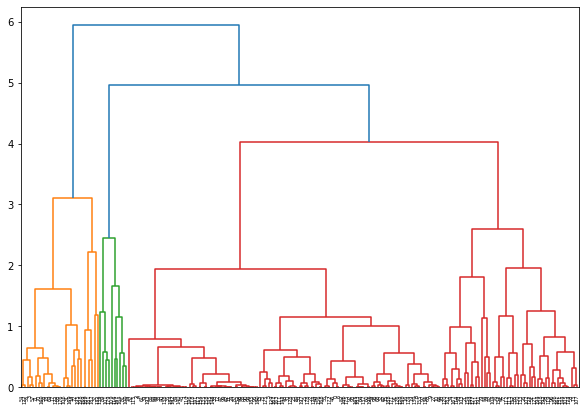

In [67]:
mergings = linkage(scaled_data, method='complete')
fig = plt.figure(figsize=(10, 7))
dendrogram(mergings)
plt.show()

In [68]:
labels = fcluster(mergings, 3.5, criterion='distance')
data['Segment'] = labels

### Results <a name="Part4"></a>

Let's use crosstab to observe which region's coffee shops are dominant in each segment.

In [69]:
pd.crosstab(data['Segment'], data['Region'], margins=True)

Region,Dnipro,Kharkiv,Kherson,Khrivoy Rog,Kiev,Lviv,Mariupol,Odessa,Poltava,Zaporozhye,All
Segment,,,,,,,,,,,
1,5,4,3,3,0,1,4,1,3,4,28
2,1,1,0,0,2,4,0,2,0,0,10
3,9,11,12,11,11,5,15,15,11,12,112
4,5,4,5,6,7,9,1,2,6,4,49
All,20,20,20,20,20,19,20,20,20,20,199


Delivery option distribution by the segments

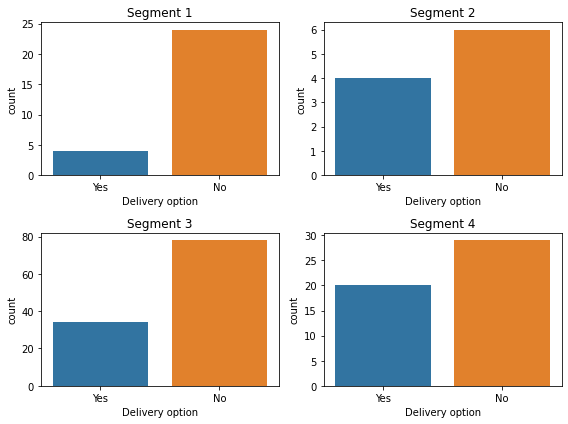

In [70]:
n_subplots = 0
fig = plt.figure(figsize=(8, 6))
for i in range(1, 5):
    n_subplots += 1
    plt.subplot(2, 2, n_subplots)
    temp_map_dict = {1: 'Yes', 0: 'No'}
    temp_df = data[data['Segment']==i]
    temp_df['Delivery option'] = temp_df['Delivery option'].map(temp_map_dict)
    sns.countplot(x='Delivery option', data = temp_df, order=['Yes', 'No'])
    plt.title(f'Segment {i}')
plt.tight_layout()

Dine in option distribution by the segments

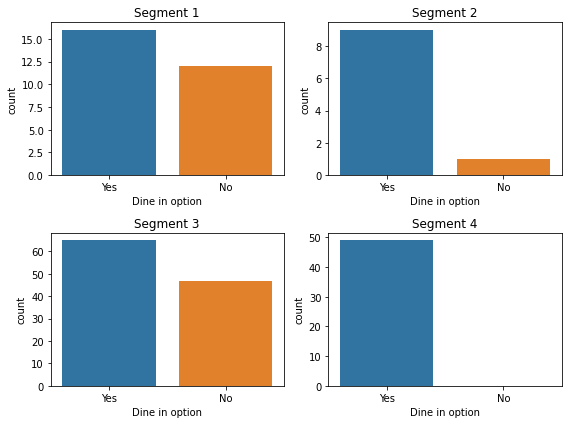

In [71]:
n_subplots = 0
fig = plt.figure(figsize=(8, 6))
for i in range(1, 5):
    n_subplots += 1
    plt.subplot(2, 2, n_subplots)
    temp_df = data[data['Segment']==i]
    temp_map_dict = {1: 'Yes', 0: 'No'}
    temp_df['Dine in option'] = temp_df['Dine in option'].map(temp_map_dict)
    sns.countplot(x='Dine in option', data = temp_df, order=['Yes', 'No'])
    plt.title(f'Segment {i}')
plt.tight_layout()

Takeout option distribution by the segments

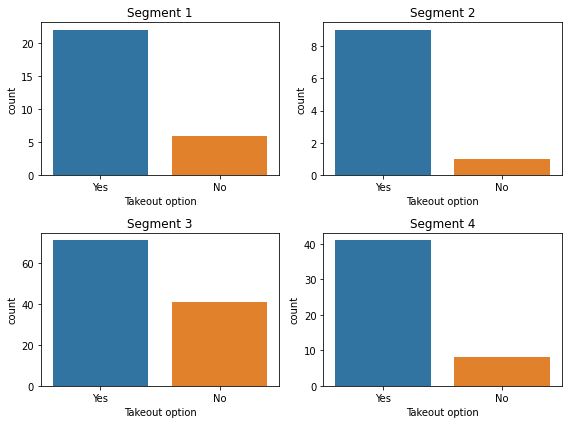

In [72]:
n_subplots = 0
fig = plt.figure(figsize=(8, 6))
for i in range(1, 5):
    n_subplots += 1
    plt.subplot(2, 2, n_subplots)
    temp_df = data[data['Segment']==i]
    temp_map_dict = {1: 'Yes', 0: 'No'}
    temp_df['Takeout option'] = temp_df['Takeout option'].map(temp_map_dict)
    sns.countplot(x='Takeout option', data = temp_df, order=['Yes', 'No'])
    plt.title(f'Segment {i}')
plt.tight_layout()

Let's show pricing by the segments.

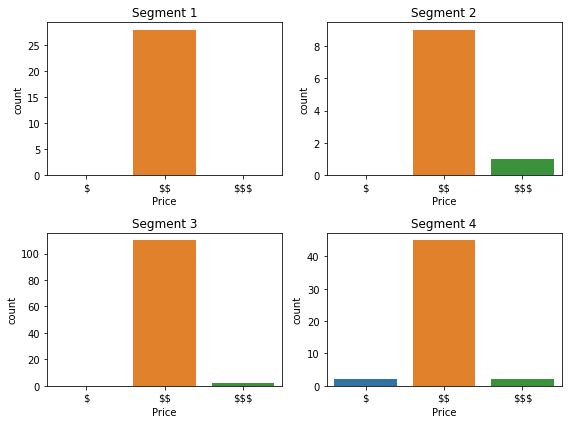

In [73]:
n_subplots = 0
fig = plt.figure(figsize=(8, 6))
for i in range(1, 5):
    n_subplots += 1
    plt.subplot(2, 2, n_subplots)
    temp_df = data[data['Segment']==i]
    temp_map_dict = {1: '\$', 2: '\$\$', 3: '\$\$\$'}
    temp_df['Price'] = temp_df['Price'].map(temp_map_dict)
    sns.countplot(x='Price', data = temp_df, order=['\$', '\$\$', '\$\$\$'])
    plt.title(f'Segment {i}')
plt.tight_layout()

Rating distribution by the segments

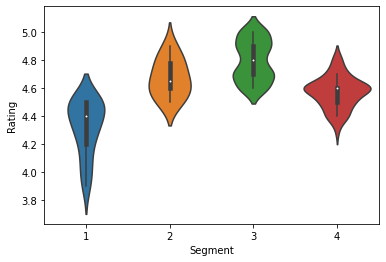

In [74]:
sns.violinplot(x='Segment', y='Rating', data=data)
plt.show()

In [75]:
data.groupby('Segment', as_index=False)['Rating'].agg(['std', 'mean', 'median'])

,std,mean,median
Segment,,,
1,0.196362,4.317857,4.40
2,0.133749,4.670000,4.65
3,0.144190,4.795536,4.80
4,0.112183,4.569388,4.60


Review distribution by segment

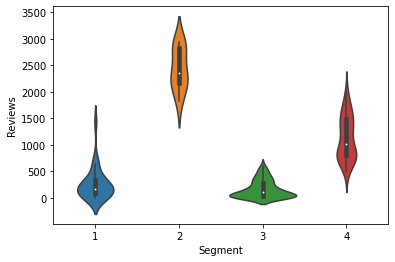

In [76]:
sns.violinplot(x='Segment', y='Reviews', data=data)
plt.show()

In [77]:
data.groupby('Segment', as_index=False)['Reviews'].agg(['std', 'mean', 'median'])

,std,mean,median
Segment,,,
1,299.870281,260.500000,168.5
2,391.235138,2440.400000,2350.0
3,164.969132,163.821429,111.5
4,404.466204,1129.081633,1009.0


The table below summarizes the characteristics for each segment derived. Specifically "Shops" column shows how many shops each segment contains. 4 columns (namely "Delivery option", "Dine in option", "Takeout option", and "High Pricing") show percentage of shops possessing column specific option in each segment. Finally "Rating" and "Review" columns contain average rating and review for each segment.

|Segment|Shops|Delivery option (%)|Dine in option (%)|Takeout option (%)|Rating|Review|High Pricing (%)|
|----------|--------|--------------------|------------------|-------------------|--------|---------|---------|
|1|28|14|57|79|4.318|260|0|
|2|10|40|90|90|4.670|2440|10|
|3|112|30|58|63|4.795|164|2|
|4|49|41|100|84|4.569|1129|4|

So in segment 1 we have 28 shops that have the lowest values in terms of average rating, high pricing, dining and delivery options, among all other shops in other segments. The shops in this segment show modest results in terms of takeout option and review on average. Segment 2 contains 10 shops with the second best result in terms of delivery option, dine in option, and average rating. The shops in this segment possess the highest results in terms of takeout option, average review, and high pricing. In segment 3 we have 112 shops showing modest results in terms of high pricing, delivery and dine in options. In addition this segment contains shops with the highest rating and the lowest takeout option and average reviews. Finally the fourth segment shows the best result in terms of delivery and dine in options. Meanwhile it possesses the second highest percentage of takeout option, high pricing, and average reviews among all other segments. This segment shows modest results in terms of average rating.